In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import math
import numpy as np
import pathlib
%matplotlib inline

linkSequentialData = 'data/sequential_data'
path = pathlib.Path().absolute().parent / linkSequentialData / 'metrics'
pathesMetrics = list(path.glob('*.csv'))
nodeNames = list(map(lambda x: x.name[:x.name.find('_')], pathesMetrics))

nodes = {}
for i in range(len(nodeNames)):
    nodes[nodeNames[i]] = {}
    nodes[nodeNames[i]]['link'] = pathesMetrics[i]
    nodes[nodeNames[i]]['data'] = pd.read_csv(nodes[nodeNames[i]]['link'])

In [2]:
timeStart = datetime.strptime('2019-11-19 18:38:39', '%Y-%m-%d %H:%M:%S')
timeEnd = datetime.strptime('2019-11-20 02:30:00', '%Y-%m-%d %H:%M:%S')
allTimestamps = list(pd.date_range(timeStart, timeEnd, freq = 'S'))

for name in nodes.keys():
    # convert string to timestamp
    nodes[name]['data']['now'] = nodes[name]['data']['now'].map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S CEST'))
    # filter out the timestamps that are outside of the experiment
    nodes[name]['dataExperiment'] = nodes[name]['data'][(nodes[name]['data']['now'] >= timeStart) & (nodes[name]['data']['now'] <= timeEnd)]

In [3]:
for name in nodes.keys():
    print('Size of metrics', name, '=', nodes[name]['dataExperiment']['now'].size)

Size of metrics wally122 = 46568
Size of metrics wally113 = 26228
Size of metrics wally124 = 47518
Size of metrics wally123 = 42831
Size of metrics wally117 = 51614


In [4]:
# calculation the mean values for each timestamp 
for name in nodes.keys():
    nodes[name]['dataExperiment'] = nodes[name]['dataExperiment'].groupby('now').mean().reset_index()

for name in nodes.keys():
    print('Size of metrics', name, 'after averaging =', nodes[name]['dataExperiment']['now'].size)

Size of metrics wally122 after averaging = 28279
Size of metrics wally113 after averaging = 23206
Size of metrics wally124 after averaging = 28280
Size of metrics wally123 after averaging = 28280
Size of metrics wally117 after averaging = 28280


In [5]:
# create array of all gaps in metrics
for name in nodes.keys():
    nodes[name]['dataExperiment']['gap'] = (nodes[name]['dataExperiment']['now'].diff()).dt.seconds > 1
    gaps = []
    timestampsAfterGaps = list(nodes[name]['dataExperiment'][nodes[name]['dataExperiment']['gap']]['now'])
    for e in timestampsAfterGaps:
        s = list(nodes[name]['dataExperiment'][nodes[name]['dataExperiment']['now'] < e].tail(1)['now'])
        g = pd.date_range(s[0], e, freq = 'S')
        g.freq = None
        g = list(g)
        gaps += g[1:-1]
    nodes[name]['gaps'] = gaps
    
for name in nodes.keys():
    print('Number of gaps in ', name,' = ', len(nodes[name]['gaps']), ' (',round(len(nodes[name]['gaps'])/len(allTimestamps) * 100,2),'%)', sep = '')

Number of gaps in wally122 = 3 (0.01%)
Number of gaps in wally113 = 5076 (17.95%)
Number of gaps in wally124 = 2 (0.01%)
Number of gaps in wally123 = 2 (0.01%)
Number of gaps in wally117 = 2 (0.01%)


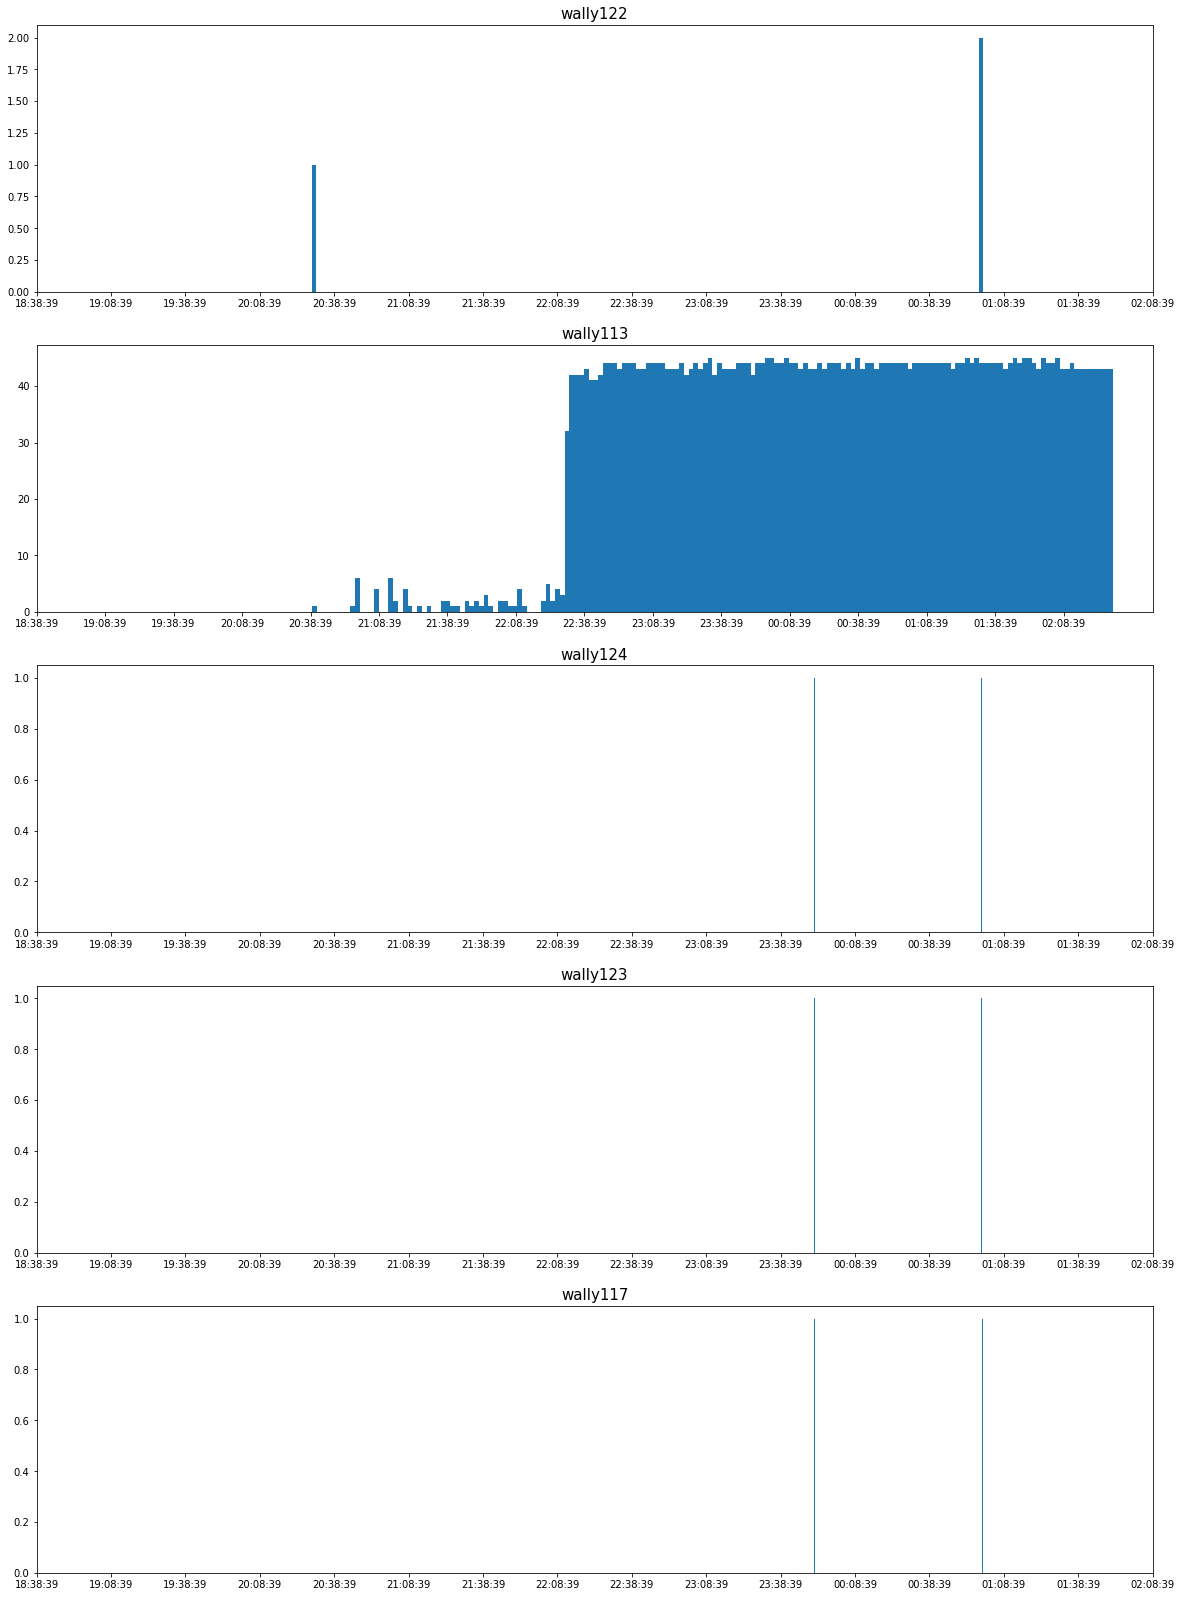

In [6]:
# plotting the distribution of gaps
fig, axes = plt.subplots(len(nodes.keys()), 1, figsize=(20, 20))

#size = round((28282) ** (1. / 3) * 2) #Rice’s Rule
#size = round(28282 / 60)
size = round(math.sqrt(len(allTimestamps)))

for i in range(len(nodeNames)):
    axes[i].hist(nodes[nodeNames[i]]['gaps'], bins = size)
    axes[i].set_title(nodeNames[i], fontsize = 15)
    
plt.subplots_adjust(top = 1.2)
myFmt = mdates.DateFormatter('%H:%M:%S')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(list(pd.date_range(timeStart, timeEnd, freq = '1800S')))
    plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

In [7]:
# calculation the max duration for all nodes
i = 0
while i < len(nodeNames):
    m1, m2 = 1, 1
    m1Time, m2Time = nodes[nodeNames[i]]['gaps'][0], nodes[nodeNames[i]]['gaps'][0]
    j = 0
    while j <= (len(nodes[nodeNames[i]]['gaps']) - 1):
        k = 1
        while (j + k < len(nodes[nodeNames[i]]['gaps'])) and ((nodes[nodeNames[i]]['gaps'][j] + timedelta(seconds = k)) == nodes[nodeNames[i]]['gaps'][j + k]):
            k += 1
        if k >= m1:
            if m1 > m2:
                m2 = m1
                m2Time = m1Time
            else: 
                m1 = k
                m1Time = nodes[nodeNames[i]]['gaps'][j]
        j += k
    nodes[nodeNames[i]]['twoGapsForPlot'] = [(m2, m2Time), (m1, m1Time)]
    i += 1
    
for name in nodes.keys():
    print('The max duration of gaps in', name,'=', nodes[name]['twoGapsForPlot'][-1][0], 'second(-s)')

The max duration of gaps in wally122 = 1 second(-s)
The max duration of gaps in wally113 = 2 second(-s)
The max duration of gaps in wally124 = 1 second(-s)
The max duration of gaps in wally123 = 1 second(-s)
The max duration of gaps in wally117 = 1 second(-s)


In [8]:
# autoscaling of y-axis based on the data
def autoscaleY(ax, xlim, margin = 0.1):

    def getYlim(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo, hi  = xlim[0], xlim[-1]
        newYd = yd[((xd >= lo) & (xd <= hi))]
        h = np.max(newYd) - np.min(newYd)
        bot = np.min(newYd) - margin * h
        top = np.max(newYd) + margin * h
        return bot,top

    lines = ax.get_lines()
    bot, top = np.inf, -np.inf

    for line in lines:
        newBot, newTop = getYlim(line)
        if newBot < bot: bot = newBot
        if newTop > top: top = newTop

    ax.set_ylim(bot * 0.95, top * 1.05)


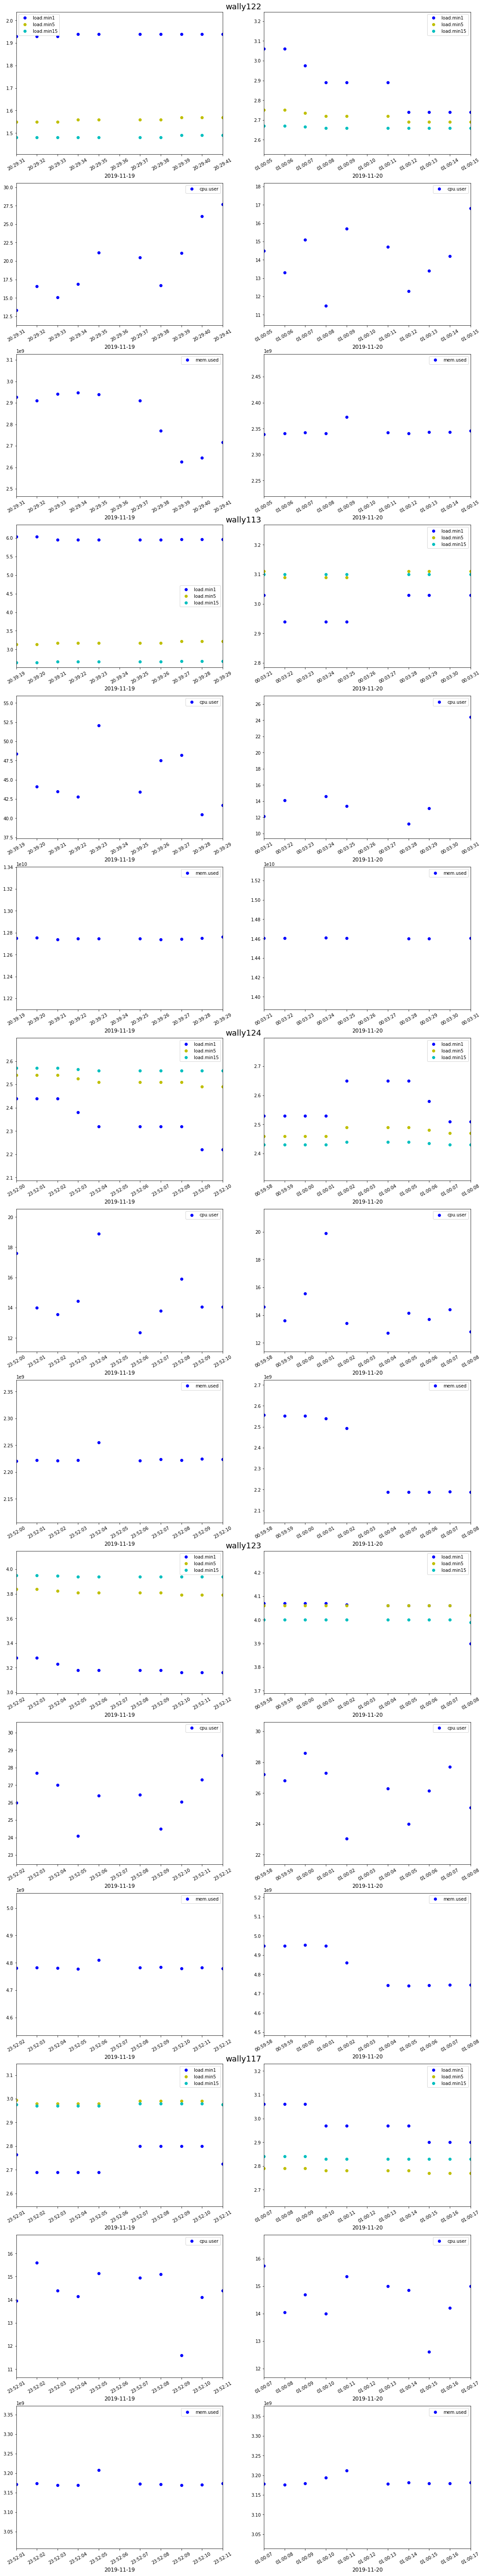

In [9]:
# plotting the load.min1, load.min2 and load.min15 for two gaps
def plotLoads(axrow, data, xlims):
    for i in range(numberOfGaps):
        axrow[i].plot('now', 'load.min1', 'bo', label = 'load.min1', data = data)
        axrow[i].plot('now', 'load.min5', 'yo', label = 'load.min5', data = data)
        axrow[i].plot('now', 'load.min15', 'co', label = 'load.min15', data = data)
        axrow[i].legend()
        axrow[i].set_xlim(xlims[i])
        g = xlims[i][0] + timedelta(seconds = 5)
        axrow[i].set_xlabel(g.date(), fontsize = 12)
        autoscaleY(axrow[i], xlims[i])
    
# plotting the cpu.user or mem.used for two gaps
def plotCpuOrMem(feature, axrow, data, xlims):
    for i in range(numberOfGaps):
        axrow[i].plot('now', feature, 'bo', label = feature, data = data)
        axrow[i].legend()
        axrow[i].set_xlim(xlims[i])
        g = xlims[i][0] + timedelta(seconds = 5)
        axrow[i].set_xlabel(g.date(), fontsize = 12)
        autoscaleY(axrow[i], xlims[i])
    
numberOfGaps = 2
fig, axes = plt.subplots(len(nodeNames) * 3, numberOfGaps)

j = 0
for i in range(0, len(axes), 3):
    twoXlims = [[nodes[nodeNames[j]]['twoGapsForPlot'][0][1] - timedelta(seconds = 5), 
                nodes[nodeNames[j]]['twoGapsForPlot'][0][1] + timedelta(seconds = 5)], 
                [nodes[nodeNames[j]]['twoGapsForPlot'][1][1] - timedelta(seconds = 5), 
                nodes[nodeNames[j]]['twoGapsForPlot'][1][1] + timedelta(seconds = 5)]]
    axes[i, 0].set_title(nodeNames[j], fontsize = 18, x = 1.1)
    plotLoads(axes[i], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    plotCpuOrMem('cpu.user', axes[i + 1], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    plotCpuOrMem('mem.used', axes[i + 2], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    j += 1

plt.subplots_adjust(top = 20, right = 2.5)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 30)

plt.show()


In [10]:
features = list(nodes[nodeNames[0]]['data'].keys())
features.remove('now')
features.remove('load.cpucore')

for feature in features:
    for name in nodes.keys():
        print('range of ', feature, ' in ', name,' is [', min(nodes[name]['dataExperiment'][feature]),', ', max(nodes[name]['dataExperiment'][feature]),']', sep = '')

range of cpu.user in wally122 is [10.0, 34.6]
range of cpu.user in wally113 is [4.8, 80.3]
range of cpu.user in wally124 is [9.5, 35.6]
range of cpu.user in wally123 is [18.5, 60.1]
range of cpu.user in wally117 is [9.8, 29.8]
range of mem.used in wally122 is [2338338816.0, 2986119168.0]
range of mem.used in wally113 is [10678829056, 15119597568]
range of mem.used in wally124 is [2185299968.0, 2937266176.0]
range of mem.used in wally123 is [2768306176.0, 5024403456.0]
range of mem.used in wally117 is [3168890880.0, 3541557248.0]
range of load.min1 in wally122 is [1.09, 4.53]
range of load.min1 in wally113 is [1.09, 7.37]
range of load.min1 in wally124 is [1.08, 3.72]
range of load.min1 in wally123 is [2.12, 5.36]
range of load.min1 in wally117 is [1.17, 4.7]
range of load.min5 in wally122 is [1.3, 3.3]
range of load.min5 in wally113 is [1.53, 5.42]
range of load.min5 in wally124 is [1.29, 2.93]
range of load.min5 in wally123 is [2.27, 4.41]
range of load.min5 in wally117 is [1.34, 3.41

In [11]:
# approximation of gaps in metrics
for name in nodes.keys():
    for gap in nodes[name]['gaps']:
        beforeTime = gap - timedelta(seconds = 1)
        afterTime = gap + timedelta(seconds = 1)
        i = 2
        while afterTime in nodes[name]['gaps']:
            afterTime = gap + timedelta(seconds = i)
            i += 1
        newRow = {'now': [gap]}
        for key in nodes[name]['data'].keys():
            if key != 'now':
                beforeRow = nodes[name]['dataExperiment'][nodes[name]['dataExperiment']['now'] == beforeTime]
                afterRow = nodes[name]['dataExperiment'][nodes[name]['dataExperiment']['now'] == afterTime]
                newRow[key] = [(beforeRow[key].values[0] + afterRow[key].values[0]) / 2]
        nodes[name]['dataExperiment'] = nodes[name]['dataExperiment'].append(pd.DataFrame(data = newRow))
    nodes[name]['dataExperiment'] = nodes[name]['dataExperiment'].sort_values(by = 'now').reset_index(drop = True)
    nodes[name]['dataExperiment'] = nodes[name]['dataExperiment'].drop('gap', 1)

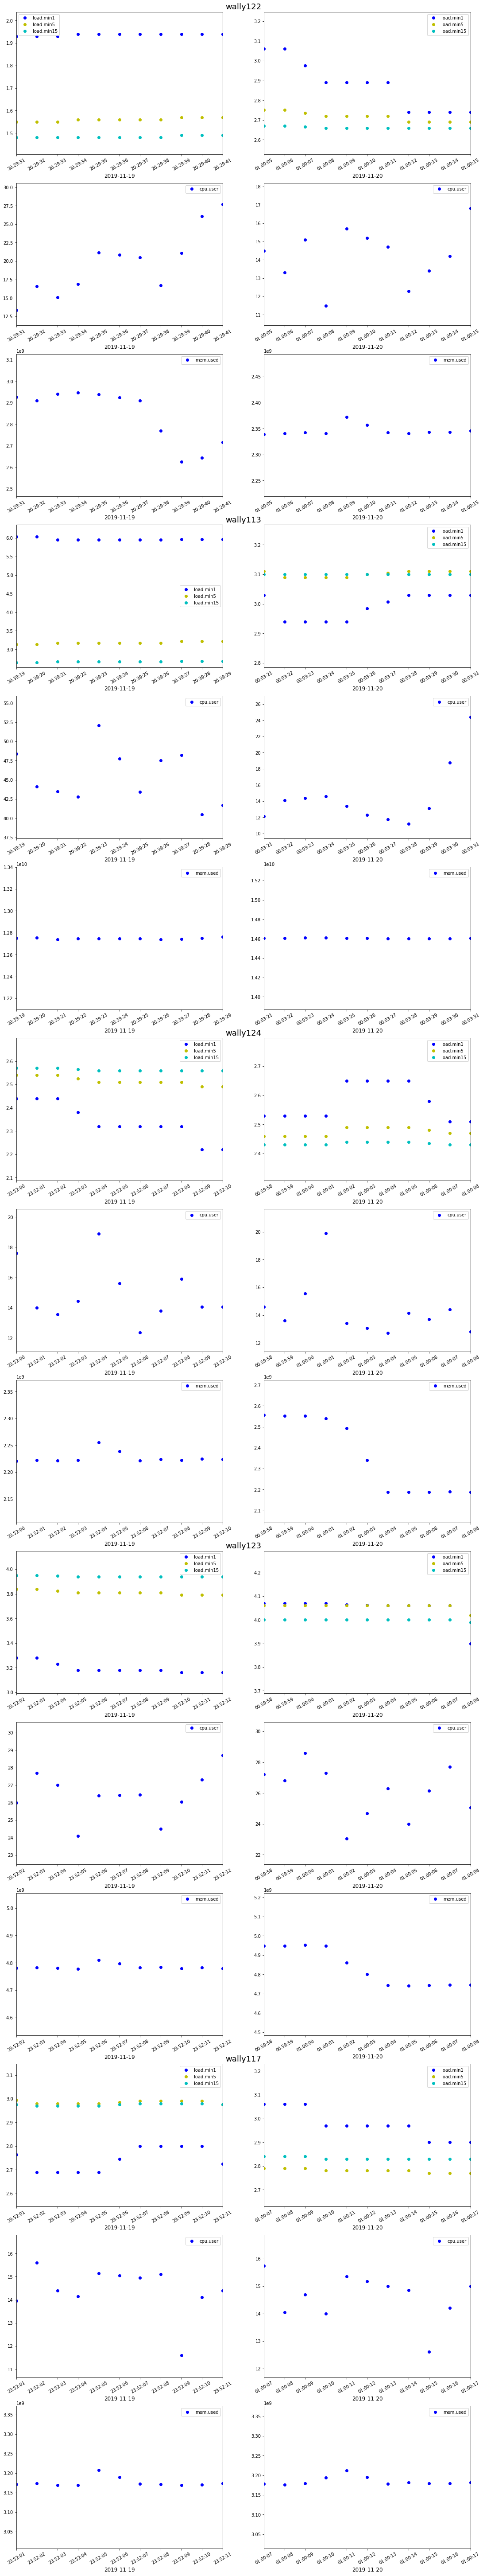

In [12]:
fig, axes = plt.subplots(len(nodeNames) * 3, numberOfGaps)

j = 0
for i in range(0, len(axes), 3):
    twoXlims = [[nodes[nodeNames[j]]['twoGapsForPlot'][0][1] - timedelta(seconds = 5), 
                nodes[nodeNames[j]]['twoGapsForPlot'][0][1] + timedelta(seconds = 5)], 
                [nodes[nodeNames[j]]['twoGapsForPlot'][1][1] - timedelta(seconds = 5), 
                nodes[nodeNames[j]]['twoGapsForPlot'][1][1] + timedelta(seconds = 5)]]
    axes[i, 0].set_title(nodeNames[j], fontsize = 18, x = 1.1)
    plotLoads(axes[i], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    plotCpuOrMem('cpu.user', axes[i + 1], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    plotCpuOrMem('mem.used', axes[i + 2], nodes[nodeNames[j]]['dataExperiment'], twoXlims)
    j += 1

plt.subplots_adjust(top = 20, right = 2.5)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 30)

plt.show()